In [1]:
import numpy as np
import adi
import matplotlib.pyplot as plt
#!pip install pyadi-iio


In [2]:
sample_rate = 1e6 # Hz
center_freq = 2915e6 # Hz
num_samps = 1024*10 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.1.16")
sdr.sample_rate = int(sample_rate)


In [3]:
# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -60 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'slow_attack'
#sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC



In [4]:
# Create transmit waveform (QPSK, 16 samples per symbol)
num_symbols = 1024
x_int = np.random.randint(0, 4, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
samples = np.repeat(x_symbols, 16) # 16 samples per symbol (rectangular pulses)
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs



In [5]:
# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(samples) # start transmitting


[  12.+258.j   -4.+267.j   14.+260.j ... -285. +20.j -279. +19.j
 -274. +24.j]


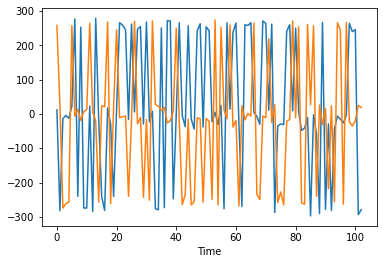

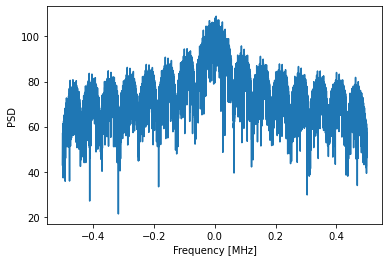

In [6]:
# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()
print(rx_samples)

# Stop transmitting
sdr.tx_destroy_buffer()

# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot time domain
plt.figure(0)
plt.plot(np.real(rx_samples[::100]))
plt.plot(np.imag(rx_samples[::100]))
plt.xlabel("Time")

# Plot freq domain
plt.figure(1)
plt.plot(f/1e6, psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()

In [7]:
# Stop transmitting
sdr.tx_destroy_buffer()

In [8]:
# Stop transmitting
sdr.tx_destroy_buffer()